# Medical Image Classification: Brain vs Lung 🧠🫁

**Simple binary classification task** - Classify medical images as Brain MRI or Lung X-ray

**Expected Performance:**
- Accuracy: >99%
- F1 Score: >0.99
- Recall: >0.99
- Precision: >0.99

**Architecture:** ConvNeXt-Tiny (ImageNet pretrained)

**Task:** Trivially separable - should converge in <5 epochs


## 1. Imports 


In [1]:
# Set environment variables to suppress HuggingFace progress bars (MUST be before any imports)
import os
os.environ['HF_HUB_DISABLE_PROGRESS_BARS'] = '1'
os.environ['HF_HUB_DISABLE_SYMLINKS_WARNING'] = '1'

import numpy as np
import pandas as pd
from pathlib import Path
from PIL import Image
import cv2
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torch.cuda.amp import autocast, GradScaler
from torchvision import transforms

import timm
import albumentations as A
from albumentations.pytorch import ToTensorV2
from tqdm import tqdm

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")


PyTorch version: 2.9.0+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4060 Laptop GPU
VRAM: 8.2 GB


## 2. Configuration 



In [ ]:
class Config:
    # Data paths - separate paths for brain and lung images
    # Brain images can be from: brain/flair/FLAIR/kaggle_3m/ (TIF files) or similar
    # Lung images can be from: siim-acr-pneumothorax/png_images/ (PNG files) or similar
    BRAIN_PATH = "brain/flair/FLAIR/kaggle_3m"  # Path to brain MRI images/rasters
    LUNG_PATH = "siim-acr-pneumothorax/png_images"  # Path to lung X-ray images
    OUTPUT_DIR = "classification_output"
    
    # Model settings
    MODEL_NAME = "convnext_tiny"  # ConvNeXt-Tiny from timm
    NUM_CLASSES = 1  # Binary classification (single logit)
    
    # Image settings
    IMAGE_SIZE = 224  # Standard for ImageNet pretrained models
    
    # Training settings
    BATCH_SIZE = 64
    LEARNING_RATE = 1e-4
    WEIGHT_DECAY = 1e-4
    EPOCHS = 2  # Should converge much faster (<5 epochs)
    PATIENCE = 3  # Early stopping patience
    
    # Data split
    VAL_SPLIT = 0.2
    TEST_SPLIT = 0.15
    
    # Other
    SEED = 42
    NUM_WORKERS = 4
    PIN_MEMORY = True
    MIXED_PRECISION = True
    USE_CLASS_REBALANCING = True  # Use WeightedRandomSampler to handle class imbalance
    
    # Device
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = Config()
os.makedirs(config.OUTPUT_DIR, exist_ok=True)

print("⚙️ Configuration:")
print(f"   Model: {config.MODEL_NAME}")
print(f"   Image Size: {config.IMAGE_SIZE}")
print(f"   Batch Size: {config.BATCH_SIZE}")
print(f"   Learning Rate: {config.LEARNING_RATE}")
print(f"   Epochs: {config.EPOCHS}")
print(f"   Device: {config.DEVICE}")


⚙️ Configuration:
   Model: convnext_tiny
   Image Size: 224
   Batch Size: 48
   Learning Rate: 0.0001
   Epochs: 2
   Device: cuda


## 3. Augmentations & Transforms 


In [3]:
# ImageNet normalization (standard for pretrained models)
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

def get_training_augmentation(image_size=224):
    """Light augmentations - task is easy, don't overcomplicate."""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.HorizontalFlip(p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.1, contrast_limit=0.1, p=0.2),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

def get_validation_augmentation(image_size=224):
    """No augmentation for validation."""
    return A.Compose([
        A.Resize(image_size, image_size),
        A.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD),
        ToTensorV2()
    ])

print("✅ Augmentations defined")


✅ Augmentations defined


## 4. Dataset Class 


In [4]:
def is_image_file(file_path):
    """Check if file is a standard image format."""
    image_extensions = {'.png', '.jpg', '.jpeg', '.bmp', '.gif', '.webp'}
    return Path(file_path).suffix.lower() in image_extensions

def convert_to_image(file_path):
    """
    Convert non-image file (like raster/TIF) to numpy array image.
    Handles various formats including TIF, TIFF, and other raster formats.
    """
    file_path = Path(file_path)
    ext = file_path.suffix.lower()
    
    # Try PIL first (handles many formats including some TIF)
    try:
        img = Image.open(file_path)
        # Convert to RGB if needed
        if img.mode != 'RGB':
            if img.mode == 'L':  # Grayscale
                img = img.convert('RGB')
            elif img.mode in ('RGBA', 'LA'):  # With alpha channel
                img = img.convert('RGB')
            else:
                img = img.convert('RGB')
        return np.array(img)
    except Exception as e:
        pass
    
    # Fallback to OpenCV (handles TIF, TIFF, and other formats)
    try:
        # Try reading as grayscale first (common for medical images)
        img = cv2.imread(str(file_path), cv2.IMREAD_GRAYSCALE)
        if img is not None:
            # Convert grayscale to RGB
            img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            return img
    except Exception as e:
        pass
    
    # Try reading as color
    try:
        img = cv2.imread(str(file_path))
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            return img
    except Exception as e:
        pass
    
    raise ValueError(f"Could not convert file to image: {file_path}")

class MedicalImageDataset(Dataset):
    """Dataset for medical image classification (brain vs lung)."""
    
    def __init__(self, image_paths, labels, transform=None):
        """
        Args:
            image_paths: List of image file paths
            labels: List of labels (0=lung, 1=brain)
            transform: Albumentations transform
        """
        self.image_paths = image_paths
        self.labels = labels
        self.transform = transform
    
    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, idx):
        image_path = self.image_paths[idx]
        label = self.labels[idx]
        
        # Check if file is already an image, otherwise convert it
        if is_image_file(image_path):
            # Standard image format - use PIL
            try:
                img = Image.open(image_path).convert('RGB')
                img = np.array(img)
            except:
                # Fallback to OpenCV
                img = cv2.imread(str(image_path))
                if img is None:
                    raise ValueError(f"Could not load image: {image_path}")
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        else:
            # Non-image format (raster, TIF, etc.) - convert it
            img = convert_to_image(image_path)
        
        # Convert grayscale to 3-channel if needed (before transforms)
        if len(img.shape) == 2:
            img = np.stack([img, img, img], axis=-1)
        elif img.shape[2] == 1:
            img = np.repeat(img, 3, axis=2)
        
        # Apply transforms (resize, normalize, to tensor)
        if self.transform:
            img = self.transform(image=img)['image']
        
        return img, torch.tensor(label, dtype=torch.float32)

print("✅ Dataset class defined")


✅ Dataset class defined


## 5. Data Loading 


In [5]:
def load_images_from_path(data_path, recursive=True, exclude_mask_files=True):
    """
    Load all image/raster files from a directory path.
    Supports both standard images and raster formats (TIF, TIFF, etc.).
    
    Args:
        data_path: Path to directory containing images
        recursive: Whether to search recursively in subdirectories
        exclude_mask_files: If True, exclude files with '_mask' in name (for segmentation datasets)
    
    Returns:
        List of file paths
    """
    data_path = Path(data_path)
    if not data_path.exists():
        return []
    
    # Supported extensions (images + rasters)
    extensions = {'.png', '.jpg', '.jpeg', '.tif', '.tiff', '.bmp', '.gif', '.webp'}
    
    file_paths = []
    if recursive:
        for file_path in data_path.rglob('*'):
            if file_path.is_file() and file_path.suffix.lower() in extensions:
                # Exclude mask files if requested (common in segmentation datasets)
                if exclude_mask_files and '_mask' in file_path.stem.lower():
                    continue
                file_paths.append(file_path)
    else:
        for file_path in data_path.glob('*'):
            if file_path.is_file() and file_path.suffix.lower() in extensions:
                if exclude_mask_files and '_mask' in file_path.stem.lower():
                    continue
                file_paths.append(file_path)
    
    return file_paths

# Load brain images (exclude mask files, handle patient folders)
print(f"📂 Loading brain images from {config.BRAIN_PATH}...")
brain_paths = load_images_from_path(config.BRAIN_PATH, recursive=True, exclude_mask_files=True)
print(f"   Found {len(brain_paths)} brain images/rasters")

# Load lung images
print(f"📂 Loading lung images from {config.LUNG_PATH}...")
lung_paths = load_images_from_path(config.LUNG_PATH, recursive=True, exclude_mask_files=True)
print(f"   Found {len(lung_paths)} lung images")

# Combine all paths and labels
all_image_paths = brain_paths + lung_paths
all_labels = np.array([1] * len(brain_paths) + [0] * len(lung_paths))  # 1=brain, 0=lung

# Validate images before splitting (filter out corrupted files)
print("\n🔍 Validating images (filtering corrupted files)...")
from concurrent.futures import ThreadPoolExecutor
import torchvision.io

def validate_image_path(image_path):
    """Validate that an image can be loaded successfully."""
    try:
        # Try to read the image using torchvision (more robust)
        img = torchvision.io.read_image(str(image_path))
        if img is None or img.numel() == 0:
            return False, image_path
        # Check basic dimensions
        if len(img.shape) < 2:
            return False, image_path
        # If we get here, image is valid
        return True, None
    except Exception:
        # If torchvision fails, try PIL as fallback
        try:
            img = Image.open(image_path)
            img.verify()  # Verify it's a valid image
            return True, None
        except Exception:
            return False, image_path

# Validate all images in parallel
valid_indices = []
corrupted_files = []

with ThreadPoolExecutor(max_workers=16) as executor:
    futures = [executor.submit(validate_image_path, path) for path in all_image_paths]
    for idx, f in enumerate(tqdm(futures, desc="Validating images", total=len(all_image_paths))):
        try:
            is_valid, corrupt_path = f.result()
            if is_valid:
                valid_indices.append(idx)
            elif corrupt_path:
                corrupted_files.append(corrupt_path)
        except Exception:
            corrupted_files.append(all_image_paths[idx])

# Filter out corrupted images
if corrupted_files:
    print(f"   ⚠️  Found {len(corrupted_files)} corrupted images (filtered out)")
    if len(corrupted_files) <= 10:
        print(f"   Corrupted files: {corrupted_files}")
    else:
        print(f"   First 10 corrupted files: {corrupted_files[:10]}")

all_image_paths = [all_image_paths[i] for i in valid_indices]
all_labels = all_labels[valid_indices]

if len(all_image_paths) == 0:
    print(f"⚠️ No images found!")
    print(f"   Brain path: {config.BRAIN_PATH}")
    print(f"   Lung path: {config.LUNG_PATH}")
else:
    print(f"\n📊 Dataset Summary:")
    print(f"   Total images: {len(all_image_paths)}")
    print(f"   Brain images: {(all_labels == 1).sum()} ({100*(all_labels == 1).mean():.1f}%)")
    print(f"   Lung images: {(all_labels == 0).sum()} ({100*(all_labels == 0).mean():.1f}%)")
    
    # Split each class separately with stratification, then combine
    brain_indices = np.where(all_labels == 1)[0]
    lung_indices = np.where(all_labels == 0)[0]
    
    # Split brain images
    brain_paths_array = np.array(all_image_paths)[brain_indices]
    brain_labels_array = all_labels[brain_indices]
    
    # Step 1: Split brain into train+val vs test
    brain_train_val_idx, brain_test_idx = train_test_split(
        np.arange(len(brain_paths_array)),
        test_size=config.TEST_SPLIT,
        random_state=config.SEED
    )
    
    # Step 2: Split brain train+val into train vs val
    adjusted_val_split = config.VAL_SPLIT / (1 - config.TEST_SPLIT)
    brain_train_idx, brain_val_idx = train_test_split(
        brain_train_val_idx,
        test_size=adjusted_val_split,
        random_state=config.SEED
    )
    
    # Split lung images
    lung_paths_array = np.array(all_image_paths)[lung_indices]
    lung_labels_array = all_labels[lung_indices]
    
    # Step 1: Split lung into train+val vs test
    lung_train_val_idx, lung_test_idx = train_test_split(
        np.arange(len(lung_paths_array)),
        test_size=config.TEST_SPLIT,
        random_state=config.SEED
    )
    
    # Step 2: Split lung train+val into train vs val
    lung_train_idx, lung_val_idx = train_test_split(
        lung_train_val_idx,
        test_size=adjusted_val_split,
        random_state=config.SEED
    )
    
    # Combine splits from both classes
    train_paths = list(brain_paths_array[brain_train_idx]) + list(lung_paths_array[lung_train_idx])
    val_paths = list(brain_paths_array[brain_val_idx]) + list(lung_paths_array[lung_val_idx])
    test_paths = list(brain_paths_array[brain_test_idx]) + list(lung_paths_array[lung_test_idx])
    
    train_labels = np.array([1] * len(brain_train_idx) + [0] * len(lung_train_idx))
    val_labels = np.array([1] * len(brain_val_idx) + [0] * len(lung_val_idx))
    test_labels = np.array([1] * len(brain_test_idx) + [0] * len(lung_test_idx))
    
    print(f"\n📂 Data Split (stratified per class):")
    print(f"   Train: {len(train_paths)} (Brain: {(train_labels == 1).sum()}, Lung: {(train_labels == 0).sum()})")
    print(f"   Val: {len(val_paths)} (Brain: {(val_labels == 1).sum()}, Lung: {(val_labels == 0).sum()})")
    print(f"   Test: {len(test_paths)} (Brain: {(test_labels == 1).sum()}, Lung: {(test_labels == 0).sum()})")
    
    print(f"\n📊 Train set class distribution:")
    print(f"   Brain: {(train_labels == 1).sum()} ({100*(train_labels == 1).mean():.1f}%)")
    print(f"   Lung: {(train_labels == 0).sum()} ({100*(train_labels == 0).mean():.1f}%)")
    
    print(f"\n📊 Test set class distribution:")
    print(f"   Brain: {(test_labels == 1).sum()} ({100*(test_labels == 1).mean():.1f}%)")
    print(f"   Lung: {(test_labels == 0).sum()} ({100*(test_labels == 0).mean():.1f}%)")
    
    # Create datasets
    train_dataset = MedicalImageDataset(train_paths, train_labels, get_training_augmentation(config.IMAGE_SIZE))
    val_dataset = MedicalImageDataset(val_paths, val_labels, get_validation_augmentation(config.IMAGE_SIZE))
    test_dataset = MedicalImageDataset(test_paths, test_labels, get_validation_augmentation(config.IMAGE_SIZE))
    
    # Create dataloaders with optional class rebalancing
    USE_CLASS_REBALANCING = config.USE_CLASS_REBALANCING
    
    if USE_CLASS_REBALANCING:
        # Calculate class weights for training set
        # Use minlength=2 to ensure we always have indices for both classes (0 and 1)
        class_counts = np.bincount(train_labels.astype(int), minlength=2)
        # Calculate inverse frequency weights (standard approach for class rebalancing)
        class_weights = 1.0 / class_counts
        sample_weights = class_weights[train_labels.astype(int)]
        
        sampler = WeightedRandomSampler(
            weights=sample_weights,
            num_samples=len(sample_weights),
            replacement=True
        )
        train_loader = DataLoader(
            train_dataset, batch_size=config.BATCH_SIZE, sampler=sampler,
            num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY, drop_last=True
        )
        print(f"   ⭐ Class rebalancing enabled: Oversampling minority class for ~50/50 balance")
        print(f"      Class counts: Brain={class_counts[1]}, Lung={class_counts[0]}")
        print(f"      Class weights: Brain={class_weights[1]:.6f}, Lung={class_weights[0]:.6f}")
    else:
        train_loader = DataLoader(
            train_dataset, batch_size=config.BATCH_SIZE, shuffle=True,
            num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
        )
        print(f"   📊 Using standard shuffling (class rebalancing disabled)")
    
    val_loader = DataLoader(
        val_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
    )
    test_loader = DataLoader(
        test_dataset, batch_size=config.BATCH_SIZE, shuffle=False,
        num_workers=config.NUM_WORKERS, pin_memory=config.PIN_MEMORY
    )
    
    print(f"\n✅ DataLoaders created:")
    print(f"   Train batches: {len(train_loader)}")
    print(f"   Val batches: {len(val_loader)}")
    print(f"   Test batches: {len(test_loader)}")


📂 Loading brain images from brain/flair/FLAIR/kaggle_3m...
   Found 3929 brain images/rasters
📂 Loading lung images from siim-acr-pneumothorax/png_images...
   Found 12047 lung images

🔍 Validating images (filtering corrupted files)...


Validating images: 100%|██████████| 15976/15976 [00:11<00:00, 1411.97it/s]

   ⚠️  Found 1 corrupted images (filtered out)
   Corrupted files: [PosixPath('siim-acr-pneumothorax/png_images/5548_train_0_.png')]

📊 Dataset Summary:
   Total images: 15975
   Brain images: 3929 (24.6%)
   Lung images: 12046 (75.4%)

📂 Data Split (stratified per class):
   Train: 10382 (Brain: 2553, Lung: 7829)
   Val: 3196 (Brain: 786, Lung: 2410)
   Test: 2397 (Brain: 590, Lung: 1807)

📊 Train set class distribution:
   Brain: 2553 (24.6%)
   Lung: 7829 (75.4%)

📊 Test set class distribution:
   Brain: 590 (24.6%)
   Lung: 1807 (75.4%)
   ⭐ Class rebalancing enabled: Oversampling minority class for ~50/50 balance
      Class counts: Brain=2553, Lung=7829
      Class weights: Brain=0.000392, Lung=0.000128

✅ DataLoaders created:
   Train batches: 216
   Val batches: 67
   Test batches: 50


In [6]:
# Create ConvNeXt-Tiny model
model = timm.create_model(
    config.MODEL_NAME,
    pretrained=True,
    num_classes=config.NUM_CLASSES  # Binary classification: 1 logit
)
model = model.to(config.DEVICE)

# Loss function - simple BCE with logits (no Dice, no Focal needed)
criterion = nn.BCEWithLogitsLoss()

# Optimizer
optimizer = optim.AdamW(
    model.parameters(),
    lr=config.LEARNING_RATE,
    weight_decay=config.WEIGHT_DECAY
)

# Scheduler (optional - task is easy, might not need it)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='max', factor=0.5, patience=2, min_lr=1e-7
)

# Mixed precision
scaler = GradScaler(enabled=config.MIXED_PRECISION)

total_params = sum(p.numel() for p in model.parameters())
print(f"\n🧠 Model: {config.MODEL_NAME}")
print(f"   Parameters: {total_params:,}")
print(f"   Loss: BCEWithLogitsLoss")
print(f"   Optimizer: AdamW (lr={config.LEARNING_RATE}, wd={config.WEIGHT_DECAY})")



🧠 Model: convnext_tiny
   Parameters: 27,820,897
   Loss: BCEWithLogitsLoss
   Optimizer: AdamW (lr=0.0001, wd=0.0001)


/tmp/ipykernel_166704/3429986376.py:25: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler(enabled=config.MIXED_PRECISION)


In [7]:
def calculate_metrics(y_true, y_pred_probs, threshold=0.5):
    """Calculate classification metrics."""
    y_pred = (y_pred_probs > threshold).astype(int)
    
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, zero_division=0)
    recall = recall_score(y_true, y_pred, zero_division=0)
    f1 = f1_score(y_true, y_pred, zero_division=0)
    
    try:
        auroc = roc_auc_score(y_true, y_pred_probs)
    except:
        auroc = 0.0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auroc': auroc
    }

# Training history
history = {
    'train_loss': [], 'train_acc': [], 'train_f1': [],
    'val_loss': [], 'val_acc': [], 'val_f1': [], 'val_precision': [], 'val_recall': []
}

best_f1 = 0.0
patience_counter = 0
best_model_path = None

print("=" * 60)
print("🚀 STARTING TRAINING")
print("=" * 60)

if train_loader is not None and val_loader is not None:
    for epoch in range(config.EPOCHS):
        # === TRAINING ===
        model.train()
        train_loss = 0.0
        train_preds = []
        train_labels = []
        
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config.EPOCHS}")
        for images, labels in pbar:
            images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
            
            optimizer.zero_grad()
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images).squeeze()
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
            
            train_loss += loss.item() * images.size(0)
            
            # Store predictions for metrics
            with torch.no_grad():
                probs = torch.sigmoid(outputs).cpu().numpy()
                train_preds.extend(probs)
                train_labels.extend(labels.cpu().numpy())
            
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})
        
        train_loss /= len(train_loader.dataset)
        train_metrics = calculate_metrics(np.array(train_labels), np.array(train_preds))
        
        # === VALIDATION ===
        model.eval()
        val_loss = 0.0
        val_preds = []
        val_labels = []
        
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
                
                with autocast(enabled=config.MIXED_PRECISION):
                    outputs = model(images).squeeze()
                    loss = criterion(outputs, labels)
                
                val_loss += loss.item() * images.size(0)
                
                probs = torch.sigmoid(outputs).cpu().numpy()
                val_preds.extend(probs)
                val_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader.dataset)
        val_metrics = calculate_metrics(np.array(val_labels), np.array(val_preds))
        
        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_metrics['accuracy'])
        history['train_f1'].append(train_metrics['f1'])
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_metrics['accuracy'])
        history['val_f1'].append(val_metrics['f1'])
        history['val_precision'].append(val_metrics['precision'])
        history['val_recall'].append(val_metrics['recall'])
        
        # Scheduler step
        scheduler.step(val_metrics['f1'])
        
        # Print metrics
        print(f"\n📊 Epoch {epoch+1}/{config.EPOCHS}:")
        print(f"   Train - Loss: {train_loss:.4f}, Acc: {train_metrics['accuracy']:.4f}, F1: {train_metrics['f1']:.4f}")
        print(f"   Val   - Loss: {val_loss:.4f}, Acc: {val_metrics['accuracy']:.4f}, F1: {val_metrics['f1']:.4f}, ")
        print(f"          Precision: {val_metrics['precision']:.4f}, Recall: {val_metrics['recall']:.4f}")
        
        # Save best model
        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            patience_counter = 0
            best_model_path = os.path.join(config.OUTPUT_DIR, f"best_model_f1{best_f1:.4f}.pth")
            torch.save({
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_f1': best_f1,
                'epoch': epoch + 1
            }, best_model_path)
            print(f"   ✅ New best model saved: F1={best_f1:.4f}")
        else:
            patience_counter += 1
            print(f"   ⏳ No improvement ({patience_counter}/{config.PATIENCE})")
        
        # Early stopping
        if patience_counter >= config.PATIENCE:
            print(f"\n⏹️  Early stopping at epoch {epoch+1}")
            break
    
    print(f"\n✅ Training complete! Best F1: {best_f1:.4f}")
else:
    print("⚠️ No data available for training")


🚀 STARTING TRAINING


Epoch 1/2:   0%|          | 0/216 [00:00<?, ?it/s]/tmp/ipykernel_166704/4203375845.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=config.MIXED_PRECISION):
Epoch 1/2: 100%|██████████| 216/216 [01:15<00:00,  2.88it/s, loss=0.0000]
/tmp/ipykernel_166704/4203375845.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=config.MIXED_PRECISION):



📊 Epoch 1/2:
   Train - Loss: 0.0244, Acc: 0.9818, F1: 0.9819
   Val   - Loss: 0.0000, Acc: 1.0000, F1: 1.0000, 
          Precision: 1.0000, Recall: 1.0000
   ✅ New best model saved: F1=1.0000


Epoch 2/2:   0%|          | 0/216 [00:00<?, ?it/s]/tmp/ipykernel_166704/4203375845.py:51: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=config.MIXED_PRECISION):
Epoch 2/2: 100%|██████████| 216/216 [01:06<00:00,  3.24it/s, loss=0.0000]
/tmp/ipykernel_166704/4203375845.py:82: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=config.MIXED_PRECISION):



📊 Epoch 2/2:
   Train - Loss: 0.0000, Acc: 1.0000, F1: 1.0000
   Val   - Loss: 0.0000, Acc: 1.0000, F1: 1.0000, 
          Precision: 1.0000, Recall: 1.0000
   ⏳ No improvement (1/3)

✅ Training complete! Best F1: 1.0000


🔍 Loading best model: best_model_f11.0000.pth


Evaluating test set:   0%|          | 0/50 [00:00<?, ?it/s]/tmp/ipykernel_166704/625901705.py:15: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=config.MIXED_PRECISION):
Evaluating test set: 100%|██████████| 50/50 [00:11<00:00,  4.38it/s]



📊 TEST SET EVALUATION
   Accuracy:  1.0000
   Precision: 1.0000
   Recall:    1.0000
   F1 Score:  1.0000
   AUROC:     1.0000


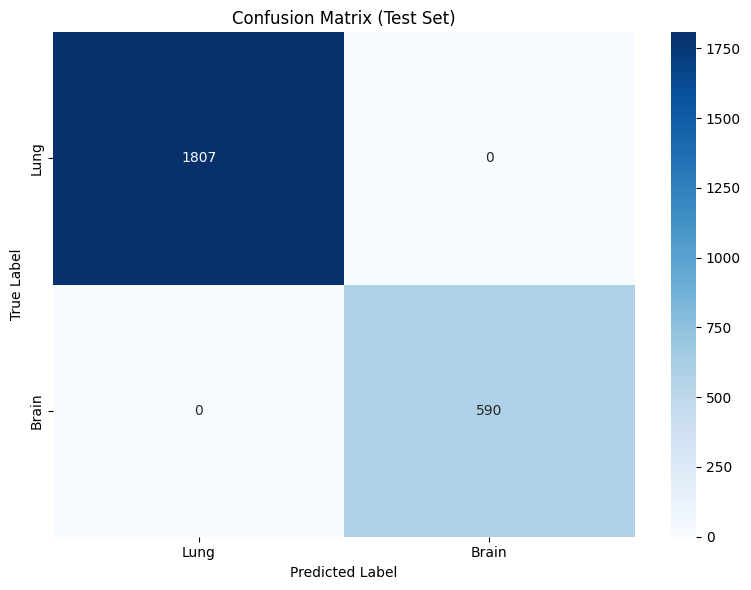

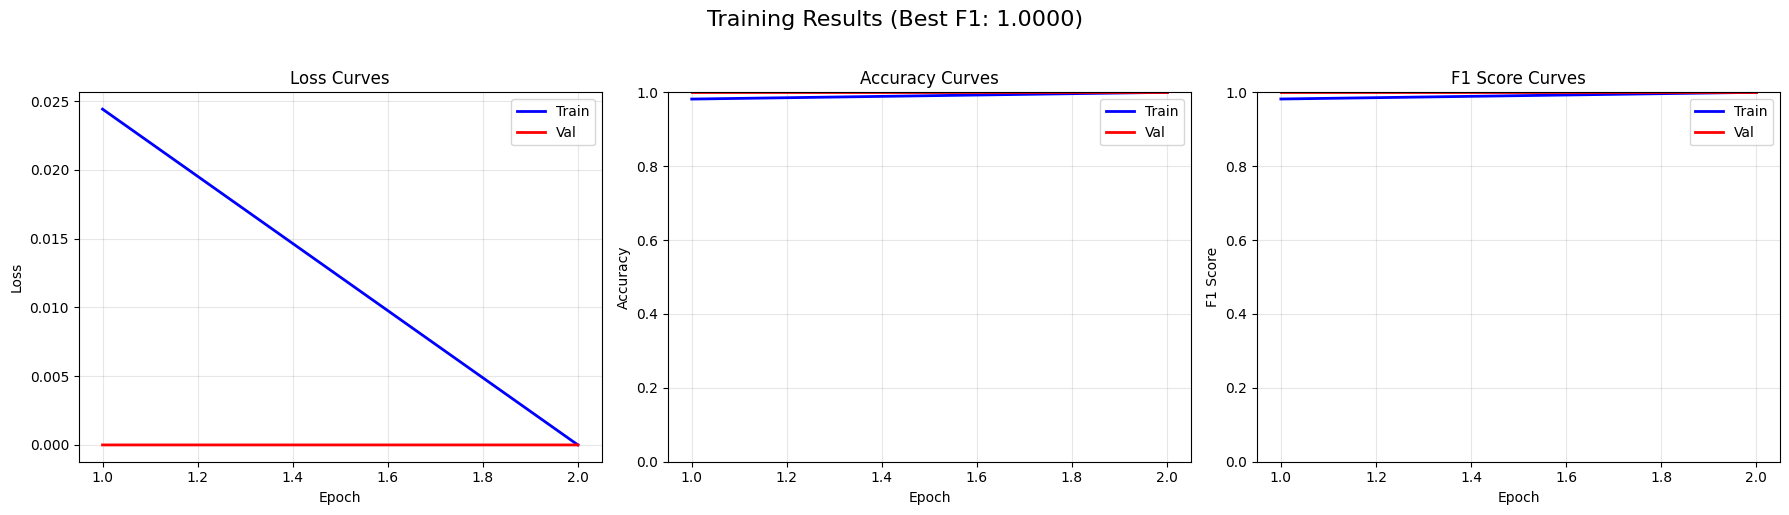

In [8]:
# Load best model and evaluate on test set
if best_model_path and os.path.exists(best_model_path):
    print(f"🔍 Loading best model: {os.path.basename(best_model_path)}")
    checkpoint = torch.load(best_model_path, map_location=config.DEVICE)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    model.eval()
    test_preds = []
    test_labels = []
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Evaluating test set"):
            images, labels = images.to(config.DEVICE), labels.to(config.DEVICE)
            
            with autocast(enabled=config.MIXED_PRECISION):
                outputs = model(images).squeeze()
            
            probs = torch.sigmoid(outputs).cpu().numpy()
            test_preds.extend(probs)
            test_labels.extend(labels.cpu().numpy())
    
    test_metrics = calculate_metrics(np.array(test_labels), np.array(test_preds))
    
    print(f"\n{'='*60}")
    print(f"📊 TEST SET EVALUATION")
    print(f"{'='*60}")
    print(f"   Accuracy:  {test_metrics['accuracy']:.4f}")
    print(f"   Precision: {test_metrics['precision']:.4f}")
    print(f"   Recall:    {test_metrics['recall']:.4f}")
    print(f"   F1 Score:  {test_metrics['f1']:.4f}")
    print(f"   AUROC:     {test_metrics['auroc']:.4f}")
    print(f"{'='*60}")
    
    # Confusion matrix
    test_pred_binary = (np.array(test_preds) > 0.5).astype(int)
    cm = confusion_matrix(test_labels, test_pred_binary)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=['Lung', 'Brain'], 
                yticklabels=['Lung', 'Brain'])
    plt.title('Confusion Matrix (Test Set)')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'confusion_matrix.png'), dpi=150)
    plt.show()
    
    # Plot training curves
    fig, axes = plt.subplots(1, 3, figsize=(18, 5))
    epochs = range(1, len(history['train_loss']) + 1)
    
    axes[0].plot(epochs, history['train_loss'], 'b-', label='Train', linewidth=2)
    axes[0].plot(epochs, history['val_loss'], 'r-', label='Val', linewidth=2)
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Curves')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(epochs, history['train_acc'], 'b-', label='Train', linewidth=2)
    axes[1].plot(epochs, history['val_acc'], 'r-', label='Val', linewidth=2)
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Curves')
    axes[1].legend()
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim(0, 1)
    
    axes[2].plot(epochs, history['train_f1'], 'b-', label='Train', linewidth=2)
    axes[2].plot(epochs, history['val_f1'], 'r-', label='Val', linewidth=2)
    axes[2].set_xlabel('Epoch')
    axes[2].set_ylabel('F1 Score')
    axes[2].set_title('F1 Score Curves')
    axes[2].legend()
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim(0, 1)
    
    plt.suptitle(f'Training Results (Best F1: {best_f1:.4f})', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.savefig(os.path.join(config.OUTPUT_DIR, 'training_curves.png'), dpi=150, bbox_inches='tight')
    plt.show()
    
else:
    print("⚠️ No trained model found")


## 9. Sample Predictions 


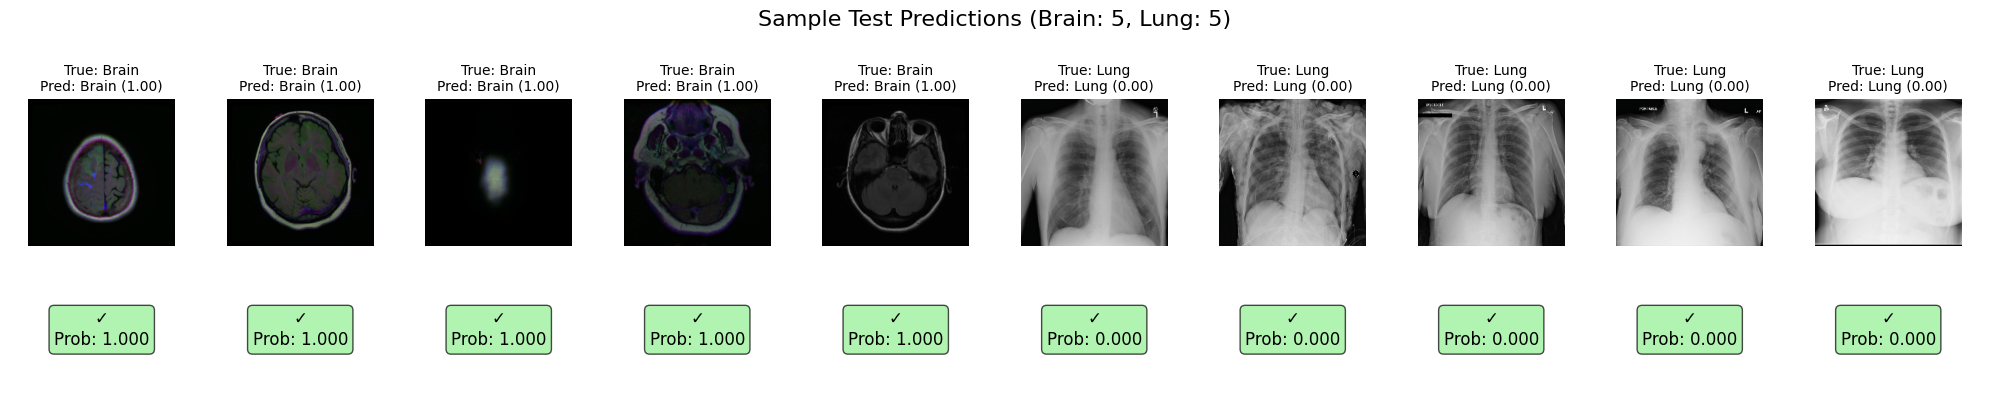

In [10]:
# Visualize some predictions from both classes
if best_model_path and os.path.exists(best_model_path) and test_loader is not None:
    model.eval()
    
    # Collect samples from both classes
    brain_samples = []
    lung_samples = []
    
    # Iterate through test dataset to find samples from both classes
    for images, labels in test_loader:
        images = images.to(config.DEVICE)
        with torch.no_grad():
            outputs = model(images).squeeze()
            probs = torch.sigmoid(outputs).cpu().numpy()
            preds = (probs > 0.5).astype(int)
        
        for i in range(len(images)):
            label = labels[i].item()
            if label == 1 and len(brain_samples) < 5:  # Brain samples
                brain_samples.append({
                    'image': images[i].cpu(),
                    'label': label,
                    'pred': preds[i],
                    'prob': probs[i]
                })
            elif label == 0 and len(lung_samples) < 5:  # Lung samples
                lung_samples.append({
                    'image': images[i].cpu(),
                    'label': label,
                    'pred': preds[i],
                    'prob': probs[i]
                })
        
        if len(brain_samples) >= 5 and len(lung_samples) >= 5:
            break
    
    # Combine samples (5 brain + 5 lung = 10 total)
    all_samples = brain_samples + lung_samples
    n_samples = len(all_samples)
    
    if n_samples == 0:
        print("⚠️ No samples found in test set")
    else:
        # Denormalize images for visualization
        mean = np.array(IMAGENET_MEAN).reshape(3, 1, 1)
        std = np.array(IMAGENET_STD).reshape(3, 1, 1)
        
        fig, axes = plt.subplots(2, n_samples, figsize=(n_samples * 2, 4))
        if n_samples == 1:
            axes = axes.reshape(2, 1)
        
        for i, sample in enumerate(all_samples):
            # Denormalize image
            img = sample['image'].numpy()
            img = img * std + mean
            img = np.clip(img, 0, 1)
            img = img.transpose(1, 2, 0)
            
            true_label = "Brain" if sample['label'] == 1 else "Lung"
            pred_label = "Brain" if sample['pred'] == 1 else "Lung"
            correct = "✓" if sample['pred'] == sample['label'] else "✗"
            
            axes[0, i].imshow(img, cmap='gray' if img.shape[2] == 1 else None)
            axes[0, i].set_title(f"True: {true_label}\nPred: {pred_label} ({sample['prob']:.2f})", fontsize=10)
            axes[0, i].axis('off')
            
            # Color code: green for correct, red for incorrect
            color = 'lightgreen' if sample['pred'] == sample['label'] else 'lightcoral'
            axes[1, i].text(0.5, 0.5, f"{correct}\nProb: {sample['prob']:.3f}", 
                            ha='center', va='center', fontsize=12,
                            bbox=dict(boxstyle='round', facecolor=color, alpha=0.7))
            axes[1, i].axis('off')
        
        plt.suptitle(f'Sample Test Predictions (Brain: {len(brain_samples)}, Lung: {len(lung_samples)})', 
                     fontsize=16, y=1.02)
        plt.tight_layout()
        plt.savefig(os.path.join(config.OUTPUT_DIR, 'sample_predictions.png'), dpi=150, bbox_inches='tight')
        plt.show()
else:
    print("⚠️ No model or test data available for visualization")
